In [14]:
import torch as th
import json
import numpy as np

dat = th.load('./input_latents.pt')
gt = "/data/mint/Motion_Dataset/Mixamo/output_mixamo/Run To Rolling/cam_0/skeleton_cam_0.json"
with open(gt, 'r') as f:
    gt = json.load(f)['joints_3d']
print(dat.shape)
print(np.array(gt).shape)


gt = np.array(gt)







torch.Size([1, 16, 19, 64, 64])
(74, 65, 3)


In [15]:
import torch.nn as nn
import torch

In [110]:
decoder_layer = nn.TransformerDecoderLayer(d_model=16, nhead=4).to('cuda')
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6).to('cuda')
joint_token = nn.Embedding(65, 16,device='cuda')
lin = nn.Linear(16, 3).to('cuda')
memory = torch.rand(10, 1, 16).to('cuda')
tgt = torch.rand(20, 1, 16).to('cuda')
out = transformer_decoder(tgt, memory)

In [115]:
import torch.nn.functional as F

In [134]:
# x: (B, T, C)
x = dat.squeeze().permute([1,0,2,3]).flatten(1).unsqueeze(0).float().to('cuda')

# move dim=1 → last
x_perm = x.permute(0, 2, 1)     # (B, C, T)

# interpolate along T
y = F.interpolate(
    x_perm,
    size=74,
    mode="linear",
    align_corners=False
)

# move back
y = y.permute(0, 2, 1).squeeze()
y = y.reshape(74,16,64,64)
y = y.flatten(2).permute([0,2,1])

In [164]:
losses = []
epoch = 5000
decoder_layer = nn.TransformerDecoderLayer(d_model=16, nhead=4).to('cuda')
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6).to('cuda')
joint_token = nn.Embedding(65, 16,device='cuda')
lin = nn.Linear(16, 3).to('cuda')
optimizer = torch.optim.Adam(list(transformer_decoder.parameters()) + list(joint_token.parameters()) + list(lin.parameters()), lr=1e-4)
for i in range(epoch):
    select_time = 0 #np.random.choice(list(range(74)))
    out = transformer_decoder(joint_token(torch.arange(65).to('cuda')).unsqueeze(1).to('cuda'),y[select_time].unsqueeze(1))
    out = lin(out.squeeze())
    y_true = torch.Tensor(gt[select_time]).to("cuda")
    loss = F.mse_loss(out, y_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {i} Loss: {loss.item()}")
    losses.append(loss.item())


Epoch 0 Loss: 1.145904302597046
Epoch 1 Loss: 0.7288640737533569
Epoch 2 Loss: 0.4408046007156372
Epoch 3 Loss: 0.2496120035648346
Epoch 4 Loss: 0.13979510962963104
Epoch 5 Loss: 0.1072690337896347
Epoch 6 Loss: 0.10950097441673279
Epoch 7 Loss: 0.11300604045391083
Epoch 8 Loss: 0.12964875996112823
Epoch 9 Loss: 0.13143181800842285
Epoch 10 Loss: 0.13073477149009705
Epoch 11 Loss: 0.13096392154693604
Epoch 12 Loss: 0.11254730820655823
Epoch 13 Loss: 0.11055366694927216
Epoch 14 Loss: 0.10996988415718079
Epoch 15 Loss: 0.10028360038995743
Epoch 16 Loss: 0.10254233330488205
Epoch 17 Loss: 0.08702286332845688
Epoch 18 Loss: 0.08608848601579666
Epoch 19 Loss: 0.07763304561376572
Epoch 20 Loss: 0.08566146343946457
Epoch 21 Loss: 0.06936919689178467
Epoch 22 Loss: 0.07480475306510925
Epoch 23 Loss: 0.08405159413814545
Epoch 24 Loss: 0.07776850461959839
Epoch 25 Loss: 0.08382389694452286
Epoch 26 Loss: 0.07751589268445969
Epoch 27 Loss: 0.0750216394662857
Epoch 28 Loss: 0.07293897867202759
Ep

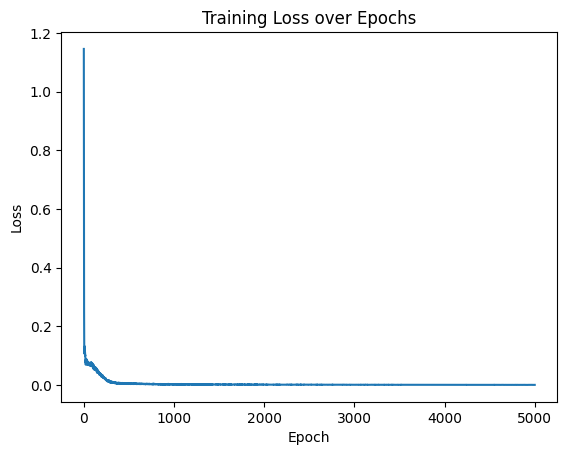

In [165]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

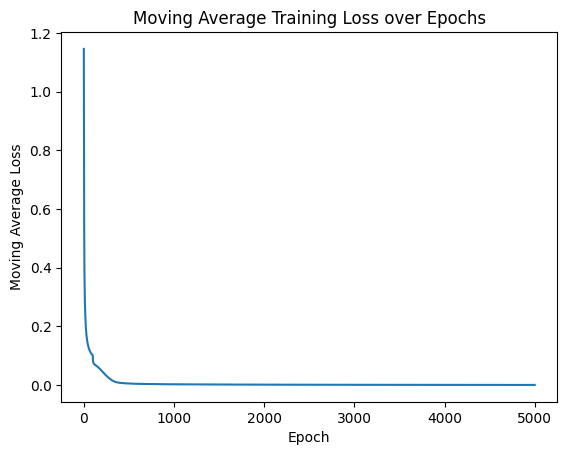

In [166]:
# plot moving average loss, froom start to current epoch
window_size = 100
moving_averages = []
for i in range(len(losses)):
    if i < window_size:
        moving_averages.append(np.mean(losses[:i+1]))
    else:
        moving_averages.append(np.mean(losses[i-window_size+1:i+1]))
plt.plot(moving_averages)
plt.xlabel('Epoch')
plt.ylabel('Moving Average Loss')
plt.title('Moving Average Training Loss over Epochs')
plt.show()


In [167]:
#use plotly to plot 3d joint, groundtruth and prediction overlayed
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=y_true[:,0].cpu().numpy(),
    y=y_true[:,1].cpu().numpy(),
    z=y_true[:,2].cpu().numpy(),
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
    ),
    name='Ground Truth'
))
fig.add_trace(go.Scatter3d(
    x=out[:,0].detach().cpu().numpy(),
    y=out[:,1].detach().cpu().numpy(),
    z=out[:,2].detach().cpu().numpy(),
    mode='markers',
    marker=dict(
        size=5,
        color='red',
    ),
    name='Prediction'
))
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Joint Positions: Ground Truth vs Prediction'
)
fig.show()

In [ ]:
#use plotly to plot 3d joint, groundtruth and prediction overlay

import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(
    x=out.detach().cpu().numpy()[:,0],
    y=out.detach().cpu().numpy()[:,1],
    z=out.detach().cpu().numpy()[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
    )
)])
fig.show()

In [161]:
#use plotly to plot 3d joint, ground truth
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(
    x=gt[select_time][:,0],
    y=gt[select_time][:,1],
    z=gt[select_time][:,2],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
    )
)])
fig.show()
#!/usr/bin/env python3

In [154]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 29.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 52.4 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.6.2 has a non-standard dependency specifier torch>=1.8.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
